# 🤖 Notebook 3 : Modélisation
## Ames Housing Dataset - Comparaison de 20+ Modèles de Régression

---

### 📋 Table des Matières
1. [Configuration](#1-configuration)
2. [Préparation des Données](#2-préparation)
3. [Baseline Model](#3-baseline)
4. [Modèles Linéaires](#4-linéaires)
5. [Modèles Arbres](#5-arbres)
6. [Modèles Boosting](#6-boosting)
7. [Autres Modèles](#7-autres)
8. [Modèles Ensemble](#8-ensemble)
9. [Comparaison Finale](#9-comparaison)

---
## 1. Configuration

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
from scipy import stats

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge, HuberRegressor, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Boosting
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print('XGBoost non disponible')

try:
    import lightgbm as lgb
    HAS_LGB = True
except ImportError:
    HAS_LGB = False
    print('LightGBM non disponible')

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except ImportError:
    HAS_CAT = False
    print('CatBoost non disponible')

warnings.filterwarnings('ignore')
np.random.seed(42)
print('✅ Configuration terminée!')

LightGBM non disponible
CatBoost non disponible
✅ Configuration terminée!


---
## 2. Préparation des Données

In [2]:
# Charger les données prétraitées
df = pd.read_csv('../data/data_preprocessed.csv')
print(f'📊 Dataset: {df.shape}')

# Séparer features et target
X = df.drop(['Id', 'SalePrice'], axis=1, errors='ignore')
y = df['SalePrice']

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'📊 Train: {X_train.shape}, Test: {X_test.shape}')

📊 Dataset: (1458, 166)
📊 Train: (1166, 164), Test: (292, 164)


In [3]:
# Fonction d'évaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    return {
        'Model': name,
        'Train_R2': r2_score(y_train, y_pred_train),
        'Test_R2': r2_score(y_test, y_pred_test),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Test_MAE': mean_absolute_error(y_test, y_pred_test),
        'Time': train_time
    }

results = []
models_dict = {}

---
## 3. Baseline Model

In [4]:
# Baseline: prédire la moyenne
baseline_pred = np.full(len(y_test), y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)
results.append({'Model': 'Baseline (Mean)', 'Train_R2': 0, 'Test_R2': baseline_r2, 'Train_RMSE': 0, 'Test_RMSE': baseline_rmse, 'Test_MAE': mean_absolute_error(y_test, baseline_pred), 'Time': 0})
print(f'📊 Baseline RMSE: {baseline_rmse:.2f}, R2: {baseline_r2:.4f}')

📊 Baseline RMSE: 74323.79, R2: -0.0001


---
## 4. Modèles Linéaires

In [5]:
# 4.1 Linear Regression
lr = LinearRegression()
results.append(evaluate_model(lr, X_train, X_test, y_train, y_test, 'Linear Regression'))
models_dict['lr'] = lr
print('✅ Linear Regression')

# 4.2 Ridge Regression
ridge = Ridge(alpha=10)
results.append(evaluate_model(ridge, X_train, X_test, y_train, y_test, 'Ridge'))
models_dict['ridge'] = ridge
print('✅ Ridge')

# 4.3 Lasso Regression
lasso = Lasso(alpha=0.001, max_iter=10000)
results.append(evaluate_model(lasso, X_train, X_test, y_train, y_test, 'Lasso'))
models_dict['lasso'] = lasso
print('✅ Lasso')

# 4.4 ElasticNet
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
results.append(evaluate_model(elastic, X_train, X_test, y_train, y_test, 'ElasticNet'))
models_dict['elastic'] = elastic
print('✅ ElasticNet')

# 4.5 SGD Regressor
sgd = SGDRegressor(max_iter=1000, random_state=42)
results.append(evaluate_model(sgd, X_train, X_test, y_train, y_test, 'SGD Regressor'))
print('✅ SGD Regressor')

# 4.6 Bayesian Ridge
bayesian = BayesianRidge()
results.append(evaluate_model(bayesian, X_train, X_test, y_train, y_test, 'Bayesian Ridge'))
print('✅ Bayesian Ridge')

# 4.7 Huber Regressor
huber = HuberRegressor(max_iter=1000)
results.append(evaluate_model(huber, X_train, X_test, y_train, y_test, 'Huber Regressor'))
print('✅ Huber Regressor')

✅ Linear Regression
✅ Ridge
✅ Lasso
✅ ElasticNet
✅ SGD Regressor
✅ Bayesian Ridge
✅ Huber Regressor


---
## 5. Modèles Arbres

In [6]:
# 5.1 Decision Tree
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
results.append(evaluate_model(dt, X_train, X_test, y_train, y_test, 'Decision Tree'))
print('✅ Decision Tree')

# 5.2 Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
results.append(evaluate_model(rf, X_train, X_test, y_train, y_test, 'Random Forest'))
models_dict['rf'] = rf
print('✅ Random Forest')

# 5.3 Extra Trees
et = ExtraTreesRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
results.append(evaluate_model(et, X_train, X_test, y_train, y_test, 'Extra Trees'))
print('✅ Extra Trees')

✅ Decision Tree
✅ Random Forest
✅ Extra Trees


---
## 6. Modèles Boosting

In [7]:
# 6.1 Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
results.append(evaluate_model(gb, X_train, X_test, y_train, y_test, 'Gradient Boosting'))
models_dict['gb'] = gb
print('✅ Gradient Boosting')

# 6.2 XGBoost
if HAS_XGB:
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbosity=0)
    results.append(evaluate_model(xgb_model, X_train, X_test, y_train, y_test, 'XGBoost'))
    models_dict['xgb'] = xgb_model
    print('✅ XGBoost')

# 6.3 LightGBM
if HAS_LGB:
    lgb_model = lgb.LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbosity=-1)
    results.append(evaluate_model(lgb_model, X_train, X_test, y_train, y_test, 'LightGBM'))
    models_dict['lgb'] = lgb_model
    print('✅ LightGBM')

# 6.4 CatBoost
if HAS_CAT:
    cat_model = CatBoostRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbose=0)
    results.append(evaluate_model(cat_model, X_train, X_test, y_train, y_test, 'CatBoost'))
    models_dict['cat'] = cat_model
    print('✅ CatBoost')

✅ Gradient Boosting
✅ XGBoost


---
## 7. Autres Modèles

In [8]:
# 7.1 K-Nearest Neighbors
knn = KNeighborsRegressor(n_neighbors=5)
results.append(evaluate_model(knn, X_train, X_test, y_train, y_test, 'KNN'))
print('✅ KNN')

# 7.2 SVR (Linear)
svr_linear = SVR(kernel='linear', C=1.0)
results.append(evaluate_model(svr_linear, X_train, X_test, y_train, y_test, 'SVR Linear'))
print('✅ SVR Linear')

# 7.3 SVR (RBF)
svr_rbf = SVR(kernel='rbf', C=1.0)
results.append(evaluate_model(svr_rbf, X_train, X_test, y_train, y_test, 'SVR RBF'))
print('✅ SVR RBF')

# 7.4 MLP
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
results.append(evaluate_model(mlp, X_train, X_test, y_train, y_test, 'MLP Regressor'))
print('✅ MLP Regressor')

✅ KNN
✅ SVR Linear
✅ SVR RBF
✅ MLP Regressor


---
## 8. Modèles Ensemble

In [9]:
# 8.1 Voting Regressor
estimators = [('rf', RandomForestRegressor(n_estimators=50, random_state=42)), ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)), ('ridge', Ridge(alpha=10))]
voting = VotingRegressor(estimators=estimators)
results.append(evaluate_model(voting, X_train, X_test, y_train, y_test, 'Voting Regressor'))
print('✅ Voting Regressor')

# 8.2 Stacking Regressor
stacking = StackingRegressor(estimators=estimators, final_estimator=Ridge())
results.append(evaluate_model(stacking, X_train, X_test, y_train, y_test, 'Stacking Regressor'))
models_dict['stacking'] = stacking
print('✅ Stacking Regressor')

# 8.3 Bagging Regressor
bagging = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), n_estimators=50, random_state=42)
results.append(evaluate_model(bagging, X_train, X_test, y_train, y_test, 'Bagging Regressor'))
print('✅ Bagging Regressor')

✅ Voting Regressor
✅ Stacking Regressor
✅ Bagging Regressor


---
## 9. Comparaison Finale

In [10]:
# Créer le DataFrame de résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)
print('📊 CLASSEMENT DES MODÈLES PAR R² TEST:')
print(results_df.to_string(index=False))

📊 CLASSEMENT DES MODÈLES PAR R² TEST:
             Model  Train_R2   Test_R2   Train_RMSE    Test_RMSE     Test_MAE     Time
       Extra Trees  0.999867  0.914177   932.269064 21773.013082 15602.780990 0.257889
  Voting Regressor  0.965899  0.909441 14903.294567 22365.690905 15212.339098 0.988070
 Gradient Boosting  0.994481  0.907617  5995.362433 22589.745585 15434.100702 0.878181
           XGBoost  0.992623  0.907050  6931.876514 22658.964495 15276.801758 0.158582
     Random Forest  0.983959  0.899259 10221.585671 23589.562212 16127.179147 0.402052
Stacking Regressor  0.962022  0.898357 15727.627454 23694.948692 15899.476496 4.875754
 Bagging Regressor  0.980484  0.895839 11274.452463 23986.589951 16548.308755 0.638477
   Huber Regressor  0.894685  0.871275 26190.550482 26665.411270 18912.210842 0.073939
             Ridge  0.905570  0.844323 24800.108437 29324.385901 20988.966364 0.011959
    Bayesian Ridge  0.895826  0.843145 26048.322148 29435.097584 21272.288744 0.015725
     

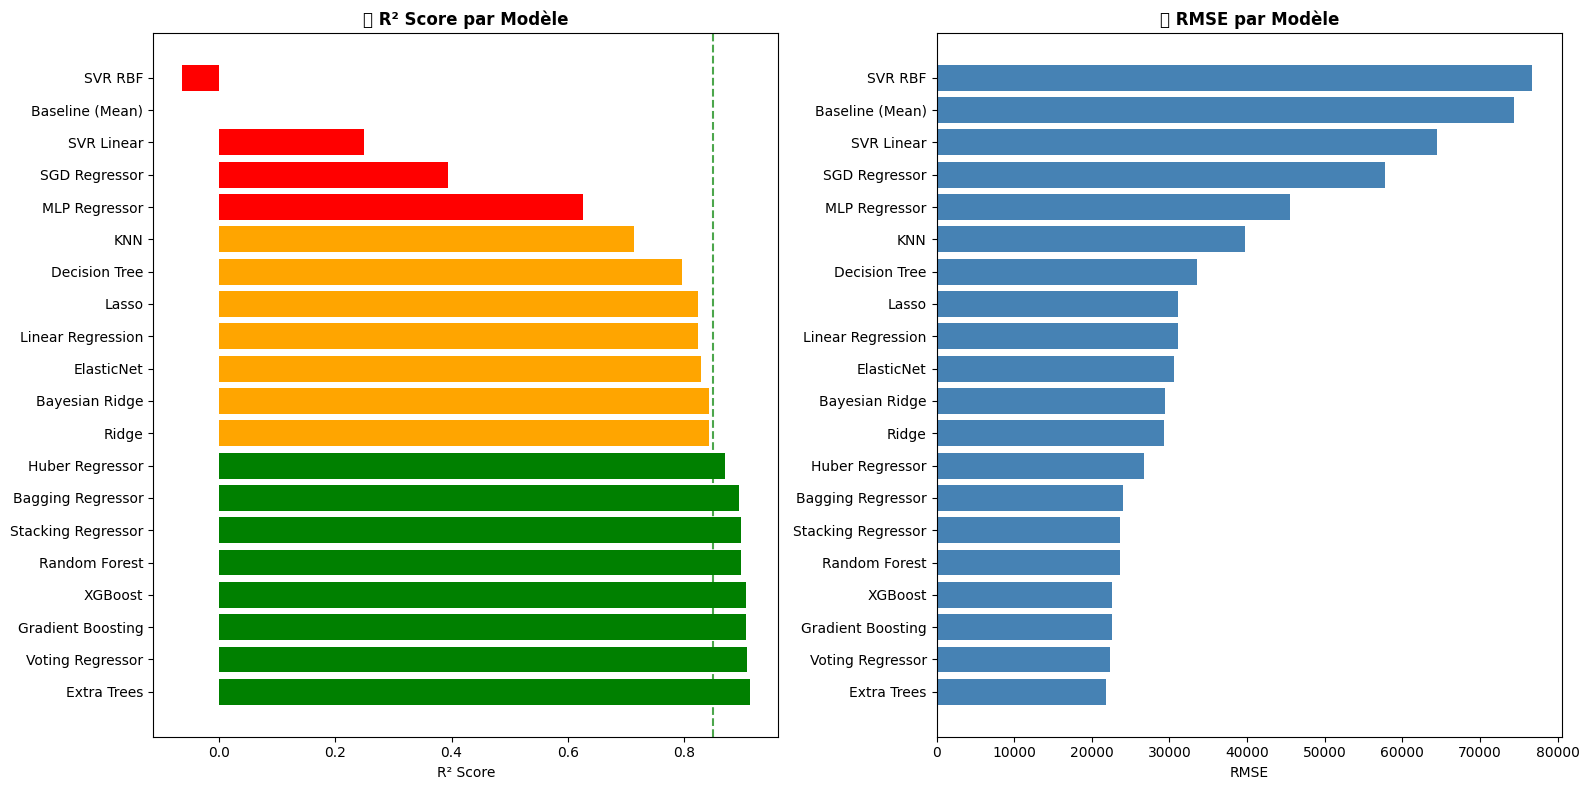

In [11]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# R² Score
ax1 = axes[0]
colors = ['green' if x > 0.85 else 'orange' if x > 0.7 else 'red' for x in results_df['Test_R2']]
ax1.barh(results_df['Model'], results_df['Test_R2'], color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('📊 R² Score par Modèle', fontweight='bold')
ax1.axvline(x=0.85, color='green', linestyle='--', alpha=0.7)

# RMSE
ax2 = axes[1]
ax2.barh(results_df['Model'], results_df['Test_RMSE'], color='steelblue')
ax2.set_xlabel('RMSE')
ax2.set_title('📊 RMSE par Modèle', fontweight='bold')

plt.tight_layout()
plt.show()

In [12]:
# Sauvegarder le meilleur modèle
best_model_name = results_df.iloc[0]['Model']
print(f'🏆 Meilleur modèle: {best_model_name}')
print(f'   R² Test: {results_df.iloc[0]["Test_R2"]:.4f}')
print(f'   RMSE Test: {results_df.iloc[0]["Test_RMSE"]:.2f}')

# Sauvegarder
import os
os.makedirs('../models', exist_ok=True)

with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump({'model': list(models_dict.values())[0], 'results': results_df}, f)

results_df.to_csv('../models/models_comparison.csv', index=False)
print('\n✅ Modèles sauvegardés!')

🏆 Meilleur modèle: Extra Trees
   R² Test: 0.9142
   RMSE Test: 21773.01

✅ Modèles sauvegardés!
